In [1]:
#importing lib
import pandas as pd
import numpy as np
#reading dataset
dataset = pd.read_csv("age_gender.csv")

In [2]:
dataset['pixels']=dataset['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))/255

In [3]:
#removing the column img_name because not relevant for the study
dataset=dataset.drop('img_name',axis=1)


## Image samples

In [4]:
import matplotlib.pyplot as plt # plotting
from math import *

def sample(xs):
  num=len(xs)
  num_row = ceil(num/5)
  num_col = num if num<5  else 5

  # plot images
  fig, axes = plt.subplots(num_row, num_col, figsize=(6*num_col,6*num_row))


  for x,i in zip(xs,[i for i in range(num)]):
    
    img = np.asarray(dataset.loc[x,"pixels"]).reshape(48, 48)
    titre = "age : " + str(dataset.loc[x,'age']) +" ethnie : "+ str(dataset.loc[x,'ethnicity'])+ " genre : "+ str(dataset.loc[x,'gender'])
    ax = axes[i//num_col, i%num_col]
    ax.imshow(img,cmap='gray', vmin=0, vmax=1)
    ax.set_title(titre,fontsize=24)

  plt.tight_layout()
  plt.show()


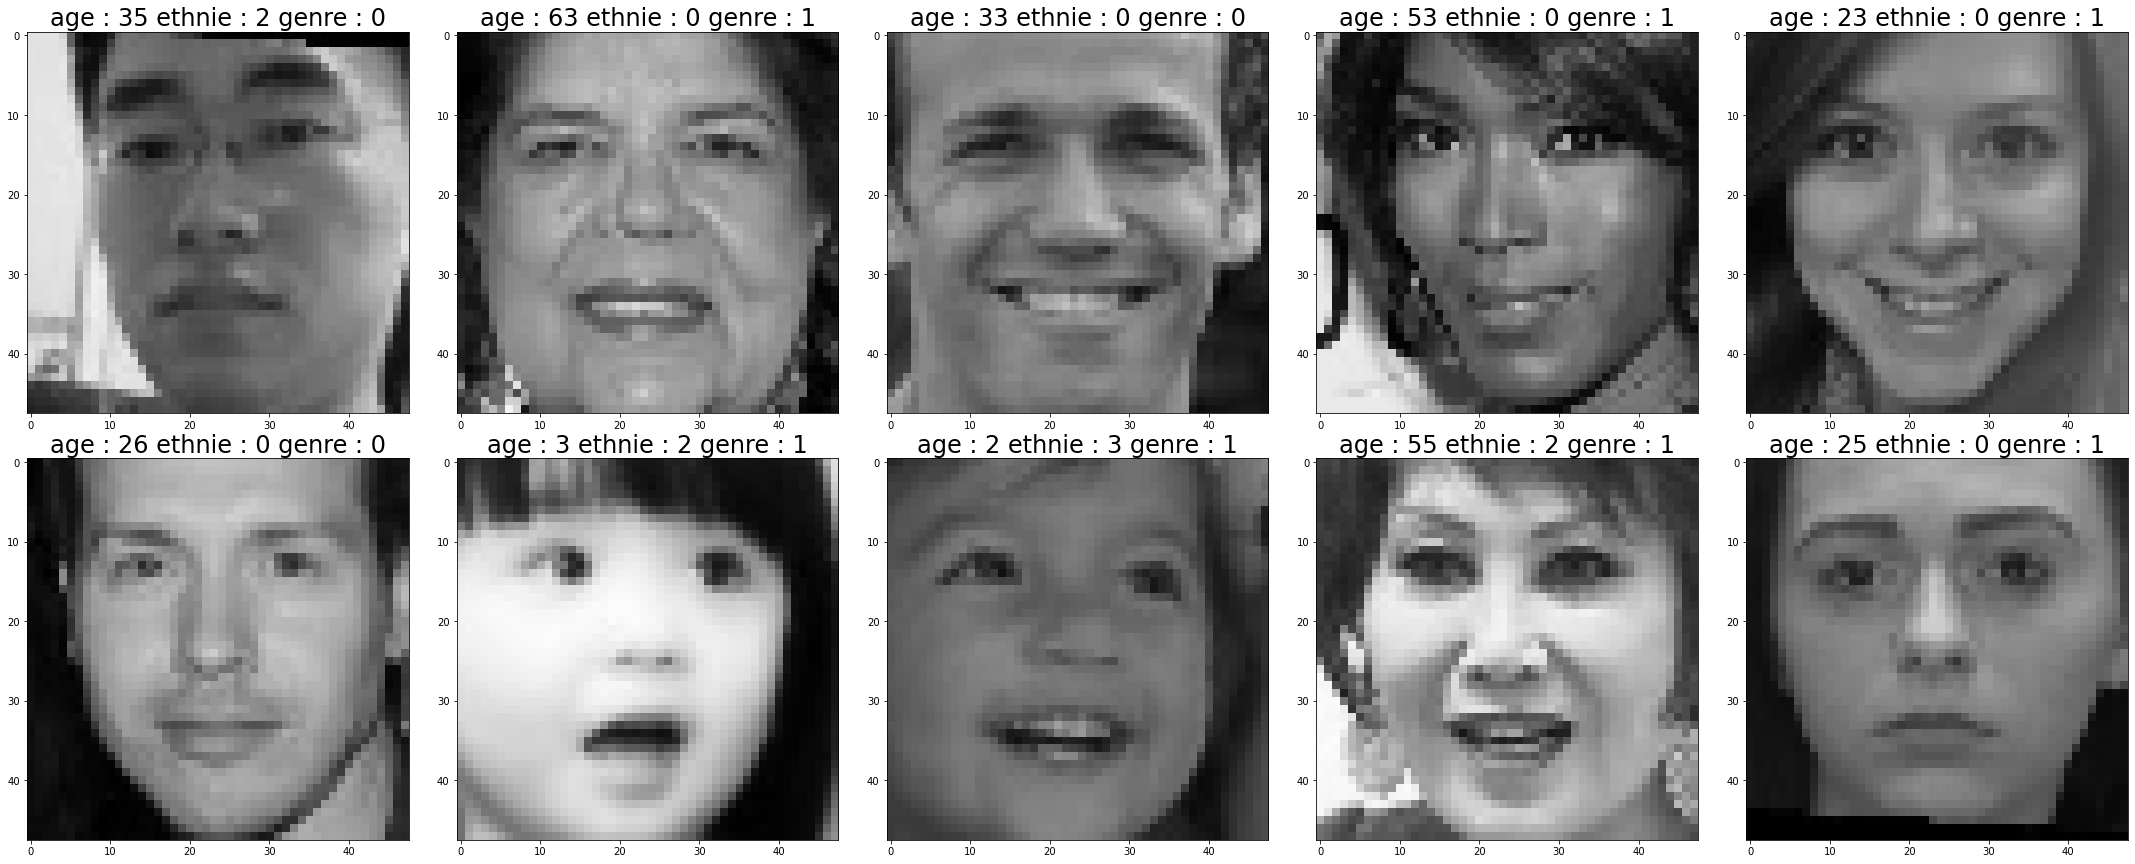

In [5]:
#the code allows to extract a batch of 10 images randomly from the dataset
import random
#sample([i for i in range(10)])
sample([random.randint(0,len(dataset)) for i in range(10)])

# EDA

In [6]:
import seaborn as sns

<AxesSubplot:xlabel='ethnicity', ylabel='count'>

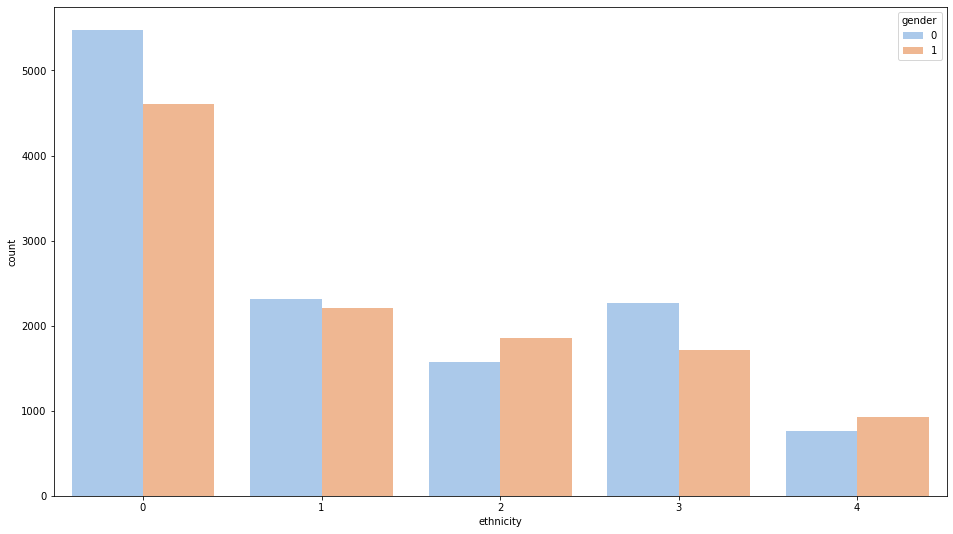

In [7]:
plt.figure(figsize=(16,9))
sns.set_palette("pastel")
sns.countplot(x ='ethnicity',hue="gender", data = dataset) 

the ethnicity variable is unbalanced with an over-representation of category 1. It will be interesting to see the capacity of our model to correctly predict under-represented categories via a confusion matrix. On the other hand, the genders are well balanced within each ethnic group.

<AxesSubplot:xlabel='gender', ylabel='count'>

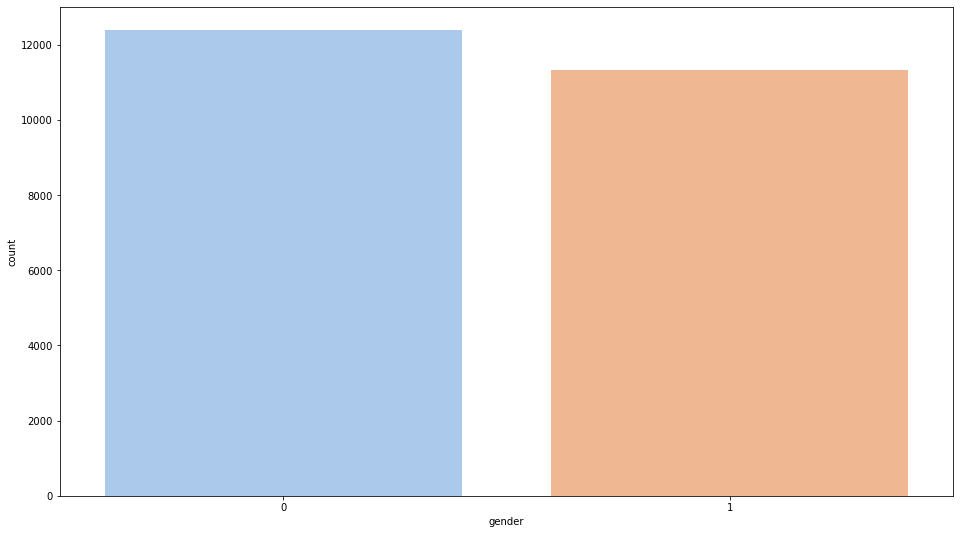

In [8]:
plt.figure(figsize=(16,9))
sns.set_palette("pastel")
sns.countplot(x ='gender', data = dataset) 

C:\Users\Night\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Night\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


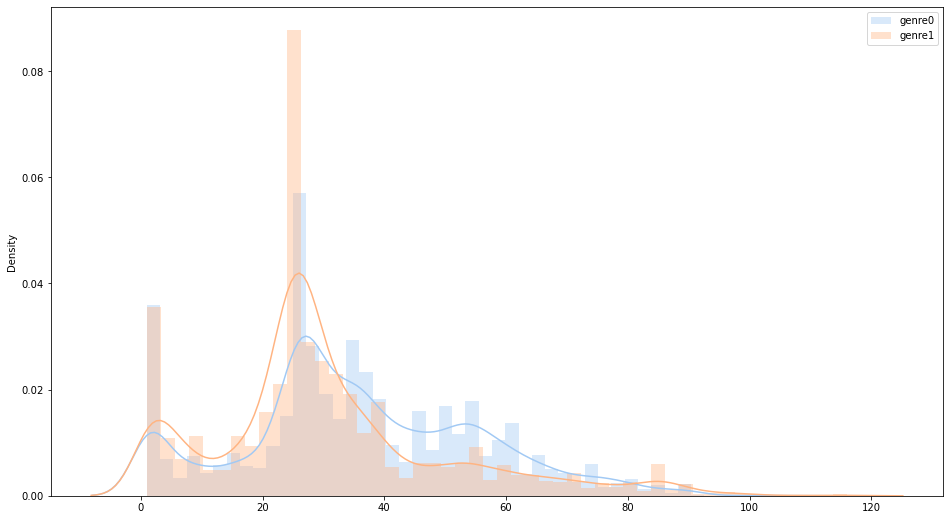

In [9]:
plt.figure(figsize=(16,9))
sns.distplot(dataset.loc[dataset.gender==0,["age"]],bins=50,label="genre0")
sns.distplot(dataset.loc[dataset.gender==1,["age"]],bins=50,label="genre1")
plt.legend()

# Data Split

In [10]:
X=dataset['pixels']

In [11]:
X_t = []
for i in range(X.shape[0]):
    X_t.append(X[i].reshape(48,48,1)) #reshaping the data to (n,48,48,1)
X = np.array(X_t)

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test, y_train_gender, y_test_gender, y_train_ethnicity, y_test_ethnicity, y_train_age, y_test_age = train_test_split(
    X,pd.get_dummies(dataset['gender']).values,pd.get_dummies(dataset['ethnicity']).values,dataset['age'].values,test_size=0.1, random_state=1234)

In [13]:
x_val, x_test, y_val_gender, y_test_gender, y_val_ethnicity, y_test_ethnicity, y_val_age, y_test_age = train_test_split(
    x_test, y_test_gender, y_test_ethnicity, y_test_age,test_size=0.5, random_state=1234)

# Model Build

In [14]:
!pip install -U keras-tuner

  Using cached keras_tuner-1.1.2-py3-none-any.whl (133 kB)
  Using cached ipython-8.4.0-py3-none-any.whl (750 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached decorator-5.1.1-py3-none-any.whl (9.1 kB)
  Using cached jedi-0.18.1-py2.py3-none-any.whl (1.6 MB)
  Using cached stack_data-0.3.0-py3-none-any.whl (23 kB)
  Using cached certifi-2022.6.15-py3-none-any.whl (160 kB)
  Using cached grpcio-1.47.0-cp310-cp310-win_amd64.whl (3.5 MB)
  Using cached google_auth-2.9.0-py2.py3-none-any.whl (167 kB)

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Python310\\share'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.



  Using cached absl_py-1.1.0-py3-none-any.whl (123 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached cachetools-5.2.0-py3-none-any.whl (9.3 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached asttokens-2.0.5-py2.py3-none-any.whl (20 kB)


In [15]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import keras
import IPython

In [16]:
def build_model(hp):
    inputs = tf.keras.Input(shape=(48, 48, 1))
    x = inputs
    for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
        filters = hp.Int('filters_' + str(i), 32, 256, step=32)
        for _ in range(2):
            x = tf.keras.layers.Convolution2D(
              filters, kernel_size=(3, 3), padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.LeakyReLU(hp.Float('alpha', 0, 0.3, step=0.01, default=0.01))(x)
            #x = tf.nn.leaky_relu(model, alpha=0.01, name='Leaky_ReLU')
            #x = tf.keras.layers.ReLU()(x) 
        if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
            x = tf.keras.layers.MaxPool2D()(x)
        else:
            x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=1024,
                                        step=32),
                           activation='relu')(x)
    x = tf.keras.layers.Dropout(
        hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
    x = layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=1024,
                                        step=32),
                           activation='relu')(x)

    out_gender = layers.Dense(2, activation='sigmoid', name='gender_out')(x) ## output binaire
    out_ethnicity = layers.Dense(5, activation='softmax', name='ethnicity_out')(x) ## output catégoriel
    out_age=layers.Dense(1, name='age_out')(x) ## output continue

    model = tf.keras.Model(inputs=inputs, outputs=[out_gender, out_ethnicity, out_age])

    model.compile(
      optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss={'gender_out':'BinaryCrossentropy',
              'ethnicity_out':'categorical_crossentropy',
              'age_out':'mse'},
        metrics={'gender_out':'accuracy',
                 'ethnicity_out':'accuracy',
                 'age_out':'mae'})
    return model

## Instantiate the tuner and perform hypertuning

In [17]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=40,
    hyperband_iterations=1,
    directory = "C:/Users/Night/Desktop/Hyper" 
    ,project_name = 'Keras_tuning')

## callback to clear the training outputs at the end of every training step

In [18]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(x_train, {'gender_out': y_train_gender, 'ethnicity_out': y_train_ethnicity, 'age_out': y_train_age},
             validation_data=(x_val, [y_val_gender, y_val_ethnicity, y_val_age]),
             callbacks= [ClearTrainingOutput()])

Trial 30 Complete [00h 42m 30s]
val_loss: 1165.1326904296875

Best val_loss So Far: 97.61085510253906
Total elapsed time: 19h 47m 19s

Search: Running Trial #31

Value             |Best Value So Far |Hyperparameter
4                 |5                 |conv_blocks
160               |32                |filters_0
0.22              |0.19              |alpha
avg               |max               |pooling_0
192               |160               |filters_1
max               |max               |pooling_1
224               |96                |filters_2
max               |avg               |pooling_2
64                |576               |units
0.3               |0.3               |dropout
0.0074414         |0.00039336        |learning_rate
224               |224               |filters_3
max               |avg               |pooling_3
256               |160               |filters_4
avg               |avg               |pooling_4
2                 |2                 |tuner/epochs
0                 

In [21]:
#best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 576 and the optimal learning rate for the optimizer
is 0.0003933636391789915.



In [22]:
#best model
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 48, 48, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 48, 48, 32)  128         ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 48, 48, 32)   0           ['batch_normalization_8[0][

 leaky_re_lu_17 (LeakyReLU)     (None, 3, 3, 160)    0           ['batch_normalization_17[0][0]'] 
                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 1, 1, 160)   0           ['leaky_re_lu_17[0][0]']         
 oling2D)                                                                                         
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 160)         0           ['average_pooling2d_3[0][0]']    
 obalAveragePooling2D)                                                                            
                                                                                                  
 flatten_1 (Flatten)            (None, 160)          0           ['global_average_pooling2d_1[0][0
                                                                 ]']                              
          

# Build the model with the optimal hyperparameters and train it on the data

In [25]:
batch_size = 32
epochs = 30


history_list = []

In [26]:
history = best_model.fit(x_train, {'gender_out': y_train_gender, 'ethnicity_out': y_train_ethnicity, 'age_out': y_train_age},
                         batch_size=batch_size,
                         epochs = epochs, validation_data = (x_val, [y_val_gender, y_val_ethnicity, y_val_age]),
                         steps_per_epoch=(x_train.shape[0] // batch_size)
                         )

history_list.append(history)

Epoch 1/30
666/666 [==============================] - 524s 787ms/step - loss: 77.5474 - gender_out_loss: 0.6574 - ethnicity_out_loss: 1.3759 - age_out_loss: 75.5141 - gender_out_accuracy: 0.6209 - ethnicity_out_accuracy: 0.4427 - age_out_mae: 6.2881 - val_loss: 176.8250 - val_gender_out_loss: 0.6108 - val_ethnicity_out_loss: 1.3930 - val_age_out_loss: 174.8212 - val_gender_out_accuracy: 0.6768 - val_ethnicity_out_accuracy: 0.4101 - val_age_out_mae: 9.0163
Epoch 2/30
666/666 [==============================] - 524s 787ms/step - loss: 65.6755 - gender_out_loss: 0.6412 - ethnicity_out_loss: 1.3508 - age_out_loss: 63.6835 - gender_out_accuracy: 0.6421 - ethnicity_out_accuracy: 0.4607 - age_out_mae: 5.8094 - val_loss: 78.2224 - val_gender_out_loss: 0.6001 - val_ethnicity_out_loss: 1.2943 - val_age_out_loss: 76.3280 - val_gender_out_accuracy: 0.6641 - val_ethnicity_out_accuracy: 0.4878 - val_age_out_mae: 6.6353
Epoch 3/30
666/666 [==============================] - 467s 701ms/step - loss: 58.8

Epoch 19/30
666/666 [==============================] - 516s 775ms/step - loss: 16.1533 - gender_out_loss: 0.4301 - ethnicity_out_loss: 1.0744 - age_out_loss: 14.6488 - gender_out_accuracy: 0.7900 - ethnicity_out_accuracy: 0.5971 - age_out_mae: 2.8643 - val_loss: 66.5910 - val_gender_out_loss: 0.3732 - val_ethnicity_out_loss: 1.1692 - val_age_out_loss: 65.0486 - val_gender_out_accuracy: 0.8177 - val_ethnicity_out_accuracy: 0.5612 - val_age_out_mae: 5.6108
Epoch 20/30
666/666 [==============================] - 507s 762ms/step - loss: 16.7559 - gender_out_loss: 0.4323 - ethnicity_out_loss: 1.0651 - age_out_loss: 15.2585 - gender_out_accuracy: 0.7915 - ethnicity_out_accuracy: 0.5988 - age_out_mae: 2.9142 - val_loss: 74.2013 - val_gender_out_loss: 0.3775 - val_ethnicity_out_loss: 1.0732 - val_age_out_loss: 72.7506 - val_gender_out_accuracy: 0.8186 - val_ethnicity_out_accuracy: 0.6008 - val_age_out_mae: 5.9076
Epoch 21/30
666/666 [==============================] - 524s 786ms/step - loss: 15.

In [27]:
from matplotlib import pyplot as plt

def plot_loss(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['gender_out_loss'], label='train_gender_loss')
    plt.plot(np.arange(0, epoch), his.history['ethnicity_out_loss'], label='train_ethnicity_loss')
    plt.plot(np.arange(0, epoch), his.history['age_out_loss'], label='train_age_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_gender_out_loss'], label='val_train_gender_loss')
    plt.plot(np.arange(0, epoch), his.history['val_ethnicity_out_loss'], label='val_train_ethnicity_loss')
    plt.plot(np.arange(0, epoch), his.history['val_age_out_loss'], label='val_train_age_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
def plot_acc(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['gender_out_accuracy'], label='train_gender_acc')
    plt.plot(np.arange(0, epoch), his.history['ethnicity_out_accuracy'], label='train_ethnicity_accuracy')
        
    plt.plot(np.arange(0, epoch), his.history['val_gender_out_accuracy'], label='val_gender_acc')
    plt.plot(np.arange(0, epoch), his.history['val_ethnicity_out_accuracy'], label='val_ethnicity_accuracy')


    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

def plot_MSE(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['age_out_mae'], label='train_age_mae')
    plt.plot(np.arange(0, epoch), his.history['val_age_out_mae'], label='val_age_mae')

    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Mean Absolute Error')
    plt.legend(loc='upper right')
    plt.show()

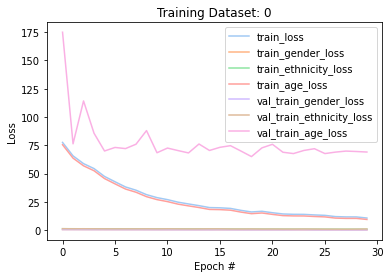

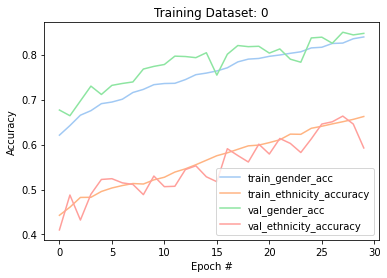

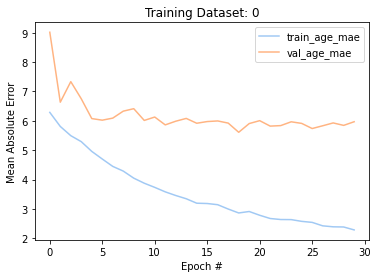

In [28]:
    plot_loss(history_list[0], epochs, f'Training Dataset: {0}')
    plot_acc(history_list[0], epochs, f'Training Dataset: {0}')
    plot_MSE(history_list[0], epochs, f'Training Dataset: {0}')

In [29]:
pred = best_model.predict(x_test)

test_loss,test_gender_loss, test_ethnicity_loss, test_age_loss, test_gender_acc,test_ethnicity_acc,test_age_mae = best_model.evaluate(x_test, [y_test_gender, y_test_ethnicity, y_test_age], verbose=0)
print(f'\nTest gender accuracy: {test_gender_acc}')
print(f'\nTest ethnicity accuracy: {test_ethnicity_acc}')
print(f'\nTest age MAE: {test_age_mae}')


Test gender accuracy: 0.8347386121749878

Test ethnicity accuracy: 0.610455334186554

Test age MAE: 5.4044599533081055


In [30]:
#Confution Matrix and Classification Report Gender

from sklearn.metrics import classification_report, confusion_matrix
Y_pred_gender = np.argmax(pred[0],axis=1)
Y_true_gender = np.argmax(y_test_gender,axis = 1)
print('Confusion Matrix')
print(confusion_matrix(Y_true_gender, Y_pred_gender))
print('Classification Report')
target_names = ['Woman', 'Man']
print(classification_report(Y_true_gender, Y_pred_gender, target_names=target_names))

Confusion Matrix
[[463 137]
 [ 59 527]]
Classification Report
              precision    recall  f1-score   support

       Woman       0.89      0.77      0.83       600
         Man       0.79      0.90      0.84       586

    accuracy                           0.83      1186
   macro avg       0.84      0.84      0.83      1186
weighted avg       0.84      0.83      0.83      1186



In [31]:
#Confution Matrix and Classification Report Ethnicity

from sklearn.metrics import classification_report, confusion_matrix
Y_pred_Ethn = np.argmax(pred[1],axis=1)
Y_true_ethnicity = np.argmax(y_test_ethnicity,axis = 1)
print('Confusion Matrix')
print(confusion_matrix(Y_true_ethnicity, Y_pred_Ethn))
print('Classification Report')
target_names = ['0', '1','2','3','4']
print(classification_report(Y_true_ethnicity, Y_pred_Ethn, target_names=target_names))

Confusion Matrix
[[460   3  43   7   0]
 [ 76 105  31  30   0]
 [ 48   0 103   1   0]
 [107   3  25  56   0]
 [ 61   0  15  12   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.61      0.90      0.73       513
           1       0.95      0.43      0.59       242
           2       0.47      0.68      0.56       152
           3       0.53      0.29      0.38       191
           4       0.00      0.00      0.00        88

    accuracy                           0.61      1186
   macro avg       0.51      0.46      0.45      1186
weighted avg       0.60      0.61      0.57      1186



C:\Users\Night\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Night\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Night\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(20, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((48,48)),cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()

## gender error

In [33]:
Y_pred_gender = np.argmax(pred[0],axis=1)
Y_true_gender = np.argmax(y_test_gender,axis = 1)

In [34]:
errors_gender = (Y_pred_gender - Y_true_gender != 0)

In [35]:
Y_pred_gender_class_errors = Y_pred_gender[errors_gender]
Y_pred_gender_errors = pred[0][errors_gender]
Y_true_errors = Y_true_gender[errors_gender]
x_val_errors = x_test[errors_gender]

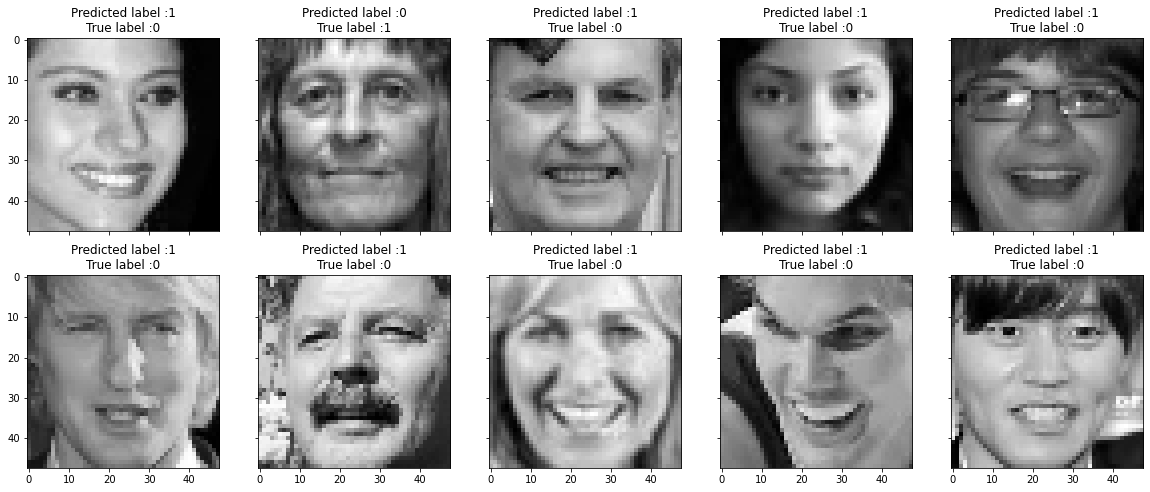

In [36]:
Y_pred_gender_errors_prob = np.max(Y_pred_gender_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_gender_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_gender_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-10:]

display_errors(most_important_errors, x_val_errors, Y_pred_gender_class_errors, Y_true_errors)

## ethnicity error

In [37]:
Y_pred_ethnicity = np.argmax(pred[1],axis=1)
Y_true_ethnicity = np.argmax(y_test_ethnicity,axis = 1)

In [38]:
errors_ethnicity = (Y_pred_ethnicity - Y_true_ethnicity != 0)

In [39]:
Y_pred_ethnicity_class_errors = Y_pred_ethnicity[errors_ethnicity]
Y_pred_ethnicity_errors = pred[1][errors_ethnicity]
Y_true_ethnicity_errors = Y_true_ethnicity[errors_ethnicity]
x_test_ethnicity_errors = x_test[errors_ethnicity]

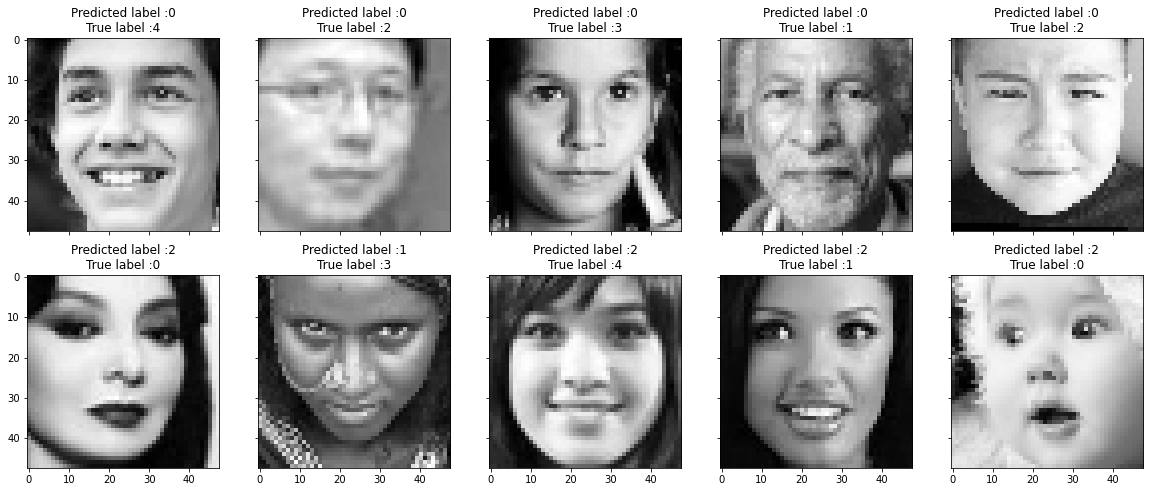

In [40]:
Y_pred_ethnicity_errors_prob = np.max(Y_pred_ethnicity_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_ethnicity_errors, Y_true_ethnicity_errors, axis=1))
delta_pred_true_ethnicity_errors = Y_pred_ethnicity_errors_prob - true_prob_errors
sorted_delta_ethnicity_errors = np.argsort(delta_pred_true_ethnicity_errors)
most_important_errors = sorted_delta_ethnicity_errors[-10:]

display_errors(most_important_errors, x_test_ethnicity_errors, Y_pred_ethnicity_class_errors, Y_true_ethnicity_errors)

## Age error

In [41]:
Y_pred_age = np.around(pred[2]).reshape(pred[2].size)
Y_true_age = y_test_age

In [42]:
MSE_age =np.sqrt((Y_pred_age-Y_true_age)**2)

In [43]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)


In [44]:
Max_MSE_age=largest_indices(MSE_age, 10)[0]

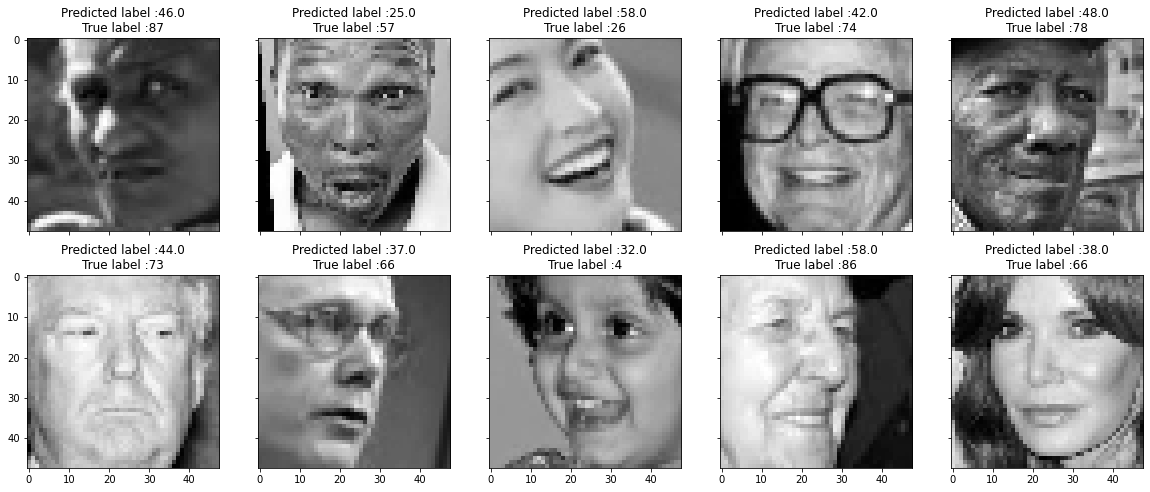

In [45]:
display_errors(Max_MSE_age, x_test, Y_pred_age, Y_true_age)

In [46]:
import os
os.getcwd()

'C:\\AkshayPersonal\\Dragon\\Computer vision R_27.07.21\\Computer vision R_27.07.21\\CV Projects 48 - Face, Gender & Ethincity recognizer model'